In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import collections
import os
import random
import numpy as np
from tqdm import tqdm
import sys, email
import pandas as pd
import math
from sklearn.metrics import precision_score, recall_score, f1_score
import datetime
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding
from tensorflow.keras.utils import to_categorical
from keras.backend import clear_session


Loading Data

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/MyDrive/MMA/'
 

In [ ]:
emails_df2 = pd.read_csv(project_path + 'enron_classification_df_new.csv') 
########## For people running locally#####
#emails_df2 = pd.read_csv('enron_classification_df.csv') 

In [ ]:
emails_df2 = emails_df2.drop(['group_LEGAL','group_COMMUICATIONS','group_SECURITY_SPAM_ALERTS','group_SUPPORT','group_ENERGY_DESK','group_SALES_DEPARTMENT','subject_length', 'subject_word_count','content_length','content_word_count','is_AM','is_weekday'], axis=1)

In [ ]:
#Slice dataset to 70,000 to save space
emails_df2 = emails_df2[:70000]

In [ ]:
len(emails_df2)

70000

In [ ]:
emails_df2['outcome'].unique()

array([5, 2, 3, 4, 1, 0])

In [ ]:
####################################################################
#Download Glove 
####################################################################
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-27 01:24:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-27 01:24:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-27 01:24:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#Download Word2Vec File
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-03-27 01:27:47--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.135.16
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.135.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.5MB/s    in 46s     

2022-03-27 01:28:35 (34.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
#load the downloaded Word2Vec
start = time.time()
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_embeddings = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  112.9201488494873


In [ ]:
# ########## People Running Locally############
# start = time.time()
# EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
# google_embeddings = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
# print("Load time (seconds): ", (time.time() - start))

In [ ]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.100d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

(400000, 300)

In [ ]:
# glove embeddings
start = time.time()

glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  53.84565830230713


Comparing Word2Vec vs Glove vs Glove w/Embeddings

In [ ]:
# Apply label encoder on the 'outcome' column to make the results to be in {0,1,2,3,4,5}corresponding to our departments
def label_encoder(data):
    class_le = LabelEncoder()    
    y = class_le.fit_transform(emails_df2['outcome'])
    return y

In [ ]:
y = label_encoder(emails_df2)
input_data = emails_df2['raw_text']

In [ ]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.2)

In [ ]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 6)
Y_test = to_categorical(y_test, 6)

In [ ]:
# prepare tokenizer to convert our words into matrix
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data)
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [ ]:
# pad documents to a max length of 150 words
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

print(X_train_padded_docs[0])

[   351  10647  27108   3755   3989   1991   1163   2350    382     53
   1152    403  10008    382    176   3755   1267    114   3989   6989
   1813    382    352   2350   3755     53   1152    403   4993   1214
    382   1302    176   3755   1267   1296    382   1090   7501  40948
   1152    382   3755  30712     22    382 106415   3755    469   3755
    578   1844   1017     22     74   2331   1456    382     92    235
   1718  27108   3755   1142  33248     53   1456    382     92    235
   1718  10647   3755     30  15762   2937   2534    176   2863  10647
  27108   3755   6894    382     64   2863   2973  15762    351    382
   4345    515   4827    182    978   4345    386    382   4345   2863
    382   4420   3539   1152   1082   4420    382   3755    757   5604
    351    182   4071   4345    382   1069    235  10647   3755   8784
    954   1152    238   3177    176   3755   1296    176   3755   1267
   1296    707    382   1163   2539    841    302   1267   1296    353
   190

Word 2 Vec 

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [ ]:
# define the model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          54649800  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 54,810,806
Trainable params: 161,006
Non-trainable params: 54,649,800
_________________________________________________________________


In [ ]:
clear_session()

In [ ]:
# train the model
clear_session()
history = model.fit(X_train_padded_docs, Y_train, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1400/1400 [==============================] - 19s 10ms/step - loss: 1.4670 - accuracy: 0.4365 - val_loss: 1.3279 - val_accuracy: 0.5132
Epoch 2/10
1400/1400 [==============================] - 13s 9ms/step - loss: 1.2559 - accuracy: 0.5393 - val_loss: 1.1195 - val_accuracy: 0.6012
Epoch 3/10
1400/1400 [==============================] - 13s 9ms/step - loss: 1.0179 - accuracy: 0.6357 - val_loss: 0.9589 - val_accuracy: 0.6527
Epoch 4/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.9159 - accuracy: 0.6720 - val_loss: 0.8859 - val_accuracy: 0.6854
Epoch 5/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.8369 - accuracy: 0.7030 - val_loss: 0.8289 - val_accuracy: 0.7054
Epoch 6/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.7641 - accuracy: 0.7294 - val_loss: 0.7621 - val_accuracy: 0.7338
Epoch 7/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.6919 - accuracy: 0.7596 - val_loss: 0.7172 - val_a

In [ ]:
# evaluate the model on the test set
accr = model.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr[0], accr[1]))

438/438 [==============================] - 3s 5ms/step - loss: 0.5886 - accuracy: 0.8021
Test Set: 
 Loss: 0.589
 Accuracy: 0.802


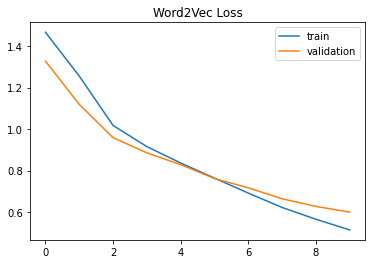

In [ ]:
# plot the loss
plt.title("Word2Vec Loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

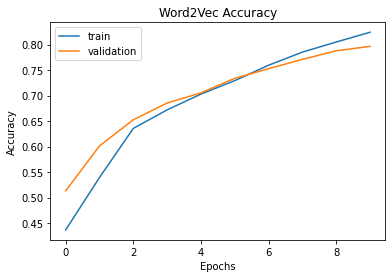

In [ ]:
# plot the accuracy
plt.title("Word2Vec Accuracy")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

Glove Dataset

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [ ]:
# define the model
model2 = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model2.add(Dense(6, activation='softmax'))


# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          54649800  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 54,810,806
Trainable params: 161,006
Non-trainable params: 54,649,800
_________________________________________________________________


In [ ]:
# fit the model
history2 = model2.fit(X_train_padded_docs, Y_train, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1400/1400 [==============================] - 15s 10ms/step - loss: 1.4204 - accuracy: 0.4503 - val_loss: 1.3069 - val_accuracy: 0.5115
Epoch 2/10
1400/1400 [==============================] - 13s 9ms/step - loss: 1.2244 - accuracy: 0.5419 - val_loss: 1.0629 - val_accuracy: 0.6031
Epoch 3/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.9510 - accuracy: 0.6554 - val_loss: 0.8563 - val_accuracy: 0.6955
Epoch 4/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.7904 - accuracy: 0.7163 - val_loss: 0.7571 - val_accuracy: 0.7334
Epoch 5/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.6723 - accuracy: 0.7635 - val_loss: 0.6934 - val_accuracy: 0.7588
Epoch 6/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.5776 - accuracy: 0.7994 - val_loss: 0.6179 - val_accuracy: 0.7897
Epoch 7/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.5003 - accuracy: 0.8279 - val_loss: 0.5706 - val_a

In [ ]:
# evaluate the model2 on the test set
accr2 = model2.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr2[0], accr2[1]))

438/438 [==============================] - 3s 5ms/step - loss: 0.4832 - accuracy: 0.8486
Test Set: 
 Loss: 0.483
 Accuracy: 0.849


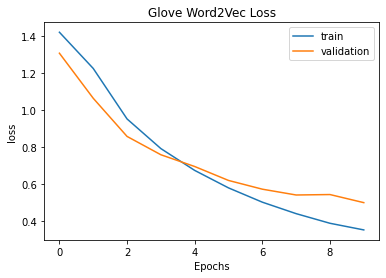

In [ ]:
# plot the loss
plt.title("Glove Word2Vec Loss")
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

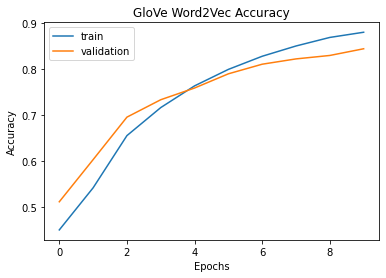

In [ ]:
# plot the accuracy
plt.title("GloVe Word2Vec Accuracy")
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

Using Glove Embeddings

In [ ]:
# define the model
model3 = Sequential()
model3.add(Embedding(vocab_size, 300, input_length=max_length))
model3.add(LSTM(100, dropout=0.2))
model3.add(Flatten())
model3.add(Dense(6, activation='softmax'))

# compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 150, 300)          54649800  
                                                                 
 lstm_28 (LSTM)              (None, 100)               160400    
                                                                 
 flatten_10 (Flatten)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 6)                 606       
                                                                 
Total params: 54,810,806
Trainable params: 54,810,806
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model
history3 = model3.fit(X_train_padded_docs, Y_train, validation_split=0.2, epochs=20, verbose=1)

Epoch 1/20
1400/1400 [==============================] - 38s 24ms/step - loss: 1.3872 - accuracy: 0.4672 - val_loss: 1.2212 - val_accuracy: 0.5510
Epoch 2/20
1400/1400 [==============================] - 34s 24ms/step - loss: 0.9896 - accuracy: 0.6379 - val_loss: 0.8754 - val_accuracy: 0.7044
Epoch 3/20
1400/1400 [==============================] - 34s 24ms/step - loss: 0.5574 - accuracy: 0.8166 - val_loss: 0.5504 - val_accuracy: 0.8309
Epoch 4/20
1400/1400 [==============================] - 34s 24ms/step - loss: 0.2593 - accuracy: 0.9189 - val_loss: 0.4527 - val_accuracy: 0.8706
Epoch 5/20
1400/1400 [==============================] - 34s 24ms/step - loss: 0.1405 - accuracy: 0.9558 - val_loss: 0.4394 - val_accuracy: 0.8840
Epoch 6/20
1400/1400 [==============================] - 34s 24ms/step - loss: 0.0912 - accuracy: 0.9704 - val_loss: 0.4506 - val_accuracy: 0.8846
Epoch 7/20
1400/1400 [==============================] - 34s 24ms/step - loss: 0.0650 - accuracy: 0.9778 - val_loss: 0.4743 -

In [ ]:
# save learned word embeddings
own_embeddings = model3.get_layer('embedding_1').get_weights()[0]

custom_w2v = {}

for word, index in t.word_index.items():
    custom_w2v[word] = own_embeddings[index]
    
import pickle    
# save to file
with open("own_embeddings.pkl", "wb") as handle:
    pickle.dump(custom_w2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load own_embeddings
#with open("own_embeddings.pkl", "rb") as handle:
 #   own_embeddings = pickle.load(handle)

In [ ]:
# evaluate the model
accr3 = model3.evaluate(X_test_padded_docs, Y_test)

print("Test Set:\n  Loss: {:0.3f}\n   Accuracy: {:0.3f}".format(accr3[0], accr3[1]))

438/438 [==============================] - 3s 5ms/step - loss: 0.5188 - accuracy: 0.8907
Test Set:
  Loss: 0.519
   Accuracy: 0.891


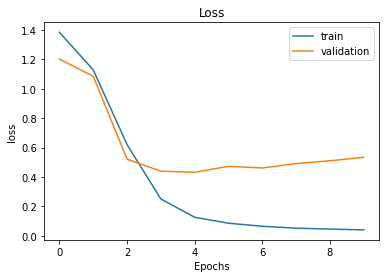

In [ ]:
# plot the loss
plt.title("Loss")
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

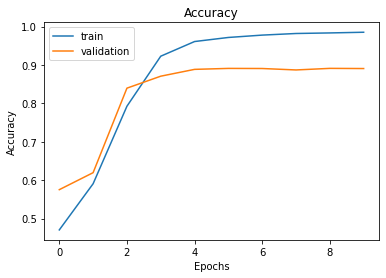

In [ ]:
# plot the accuracy
plt.title("Accuracy")
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# create a dataframe to store results
res_data = {
    "Technique": ['Word2Vec', 'GloVe', 'Glove w/ Embeddings'],
    "test accuracy": [accr[1], accr2[1], accr3[1]]
}
result = pd.DataFrame(res_data)
result

,Technique,test accuracy
0,Word2Vec,0.802071
1,GloVe,0.848571
2,Glove w/ Embeddings,0.890714


Using CNN w Embeddings

In [ ]:
emails_df2.dtypes

raw_text    object
outcome      int64
dtype: object

In [ ]:
samples = []
labels = []
for index, row in emails_df2.iterrows():
    samples.append(row['raw_text'])
    labels.append(row['outcome'])

                

In [ ]:
len(samples)

70000

In [ ]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

In [ ]:
X_train

35945    ['new enrononline functionality several change...
8344     ['rankings http rivals rivals com default asp ...
39697    ['alonzo williams michelle please try give cal...
65078    ['feel sorry pg e following summary pg e ctc r...
42113    ['forestweb prices bloomberg professional serv...
                               ...                        
3017     ['spreads think would rally march thing traded...
59899    ['confidential ca customer letter note sent ca...
846      [' lucy rentroll friday sorry late problems re...
22452    ['potential outsourcing customers gas financia...
18386    ['far east write ups following write ups tim p...
Name: raw_text, Length: 56000, dtype: object

In [ ]:
#Our layer will look at the top 20,000 words, and will truncate or pad sequences to be  200 tokens long.
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)


In [ ]:
path_to_glove_file = GLOVE_DATASET_PATH = 'glove.6B.300d.txt'
embeddings_index = {}
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [ ]:
#Here's a dict mapping words to their indices:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
#prepare a corresponding embedding matrix that we can use in Keras

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17974 words (2026 misses)


In [ ]:
import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [ ]:
class_names = ['LEGAL', 'COMMUICATIONS', 'SECURITY_SPAM_ALERTS', 'SUPPORT', 'ENERGY_DESK', 'SALES_DEPARTMENT']


In [ ]:
#A simple 1D convnet with global max pooling and a classifier at the end.

from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(128, 4, activation="relu")(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(128, 4, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         6000600   
                                                                 
 conv1d_15 (Conv1D)          (None, None, 128)         153728    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, None, 128)         65664     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                      

In [ ]:
len(X_train)

56000

In [ ]:
#convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

x_train = vectorizer(train_samples)
x_val = vectorizer(val_samples)

y_train = np.array(train_labels)
y_val = np.array(val_labels)


In [ ]:
tf.keras.optimizers.SGD(
    learning_rate=0.1,
    momentum=0.1,
    nesterov=False,
    name='SGD',
)

In [ ]:
#We use categorical crossentropy as our loss since we're doing softmax classification. Moreover, we use sparse_categorical_crossentropy since our labels are integers
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="SGD", metrics=["acc"]
)


In [ ]:
history4 =model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0170 - acc: 0.9950 - val_loss: 0.6678 - val_acc: 0.9084
Epoch 2/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.6991 - val_acc: 0.9091
Epoch 3/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0064 - acc: 0.9982 - val_loss: 0.7276 - val_acc: 0.9099
Epoch 4/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0051 - acc: 0.9985 - val_loss: 0.7459 - val_acc: 0.9098
Epoch 5/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0044 - acc: 0.9985 - val_loss: 0.7622 - val_acc: 0.9098
Epoch 6/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.7791 - val_acc: 0.9103
Epoch 7/10
438/438 [==============================] - 4s 9ms/step - loss: 0.0035 - acc: 0.9988 - val_loss: 0.7937 - val_acc: 0.9092
Epoch 8/10
438/438 [==============================] - 4s 9ms/step - loss: 0.

In [ ]:
# evaluate the model
accr4 = model.evaluate(x_val, y_val)

print("Test Set:\n  Loss: {:0.3f}\n   Accuracy: {:0.3f}".format(accr4[0], accr4[1]))

438/438 [==============================] - 1s 2ms/step - loss: 0.8271 - acc: 0.9100
Test Set:
  Loss: 0.827
   Accuracy: 0.910


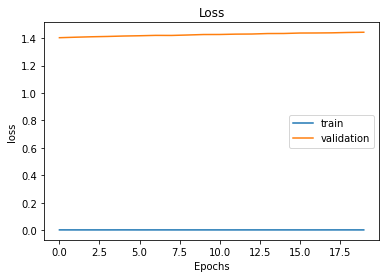

In [ ]:
# plot the loss
plt.title("Loss")
plt.plot(history4.history['loss'], label='train')
plt.plot(history4.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()


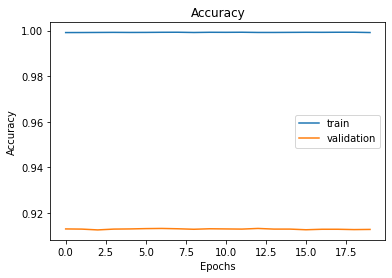

In [ ]:
# plot the accuracy
plt.title("Accuracy")
plt.plot(history4.history['acc'], label='train')
plt.plot(history4.history['val_acc'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# create a dataframe to store results
res_data = {
    "Technique": ['Word2Vec', 'GloVe', 'Glove w/ Embeddings','CNN w/ Embeddings'],
    "test accuracy": [accr[1], accr2[1], accr3[1],accr4[1]]
}
result = pd.DataFrame(res_data)
result

,Technique,test accuracy
0,Word2Vec,0.802071
1,GloVe,0.848571
2,Glove w/ Embeddings,0.890714
3,CNN w/ Embeddings,0.910000


In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["I HATE HOW YOU HAVE TREATED MY CLIENT, YOU WILL HEAR FROM MY LAWYERS SOON!"]]
)

print('Forward request to: ' + class_names[np.argmax(probabilities[0])])


Forward request to: LEGAL


Visualization

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Setting up Confusion Matrix
y_predict=model.predict(x_val)
y_predict2= np.argmax(y_predict, axis=1)
y_true=y_val

In [ ]:
lookup = {'LEGAL','COMMUICATIONS','SECURITY', 'SUPPORT', 'ENERGY', 'SALES'}

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_predict2)

Confusion matrix, without normalization
[[2346   43   36  105   26   93]
 [  37 1196   12   63    9   31]
 [  18   20  688   30    9   27]
 [  69   43   17 4438   20  133]
 [  26    5   11   21  678   48]
 [  97   36   25  115   35 3394]]


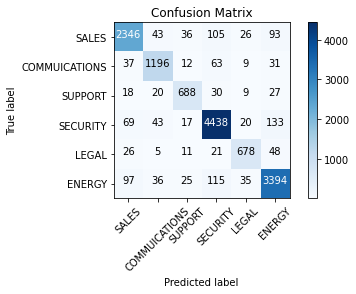

In [ ]:
plot_confusion_matrix(cm=cm, classes=lookup, title='Confusion Matrix')

In [ ]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [ ]:
np.mean(recall)

0.892985999041664

In [ ]:
np.mean(precision)

0.8967947697577049

Zero Shot Transformer Comparison

In [ ]:
pip install flair

In [ ]:
from flair.models import TARSClassifier
from flair.data import Sentence

# 1. Load our pre-trained TARS model for English
tars = TARSClassifier.load('tars-base')

# 2. Prepare a test sentence
sentence = Sentence("Hello, my computer isnt working, i need help")
# 3. Define some classes that you want to predict using descriptive names
classes = ["LEGAL", "COMMUICATIONS", "SECURITY", "SUPPORT", "ENERGY", "SALES"]

#4. Predict for these classes
tars.predict_zero_shot(sentence, classes)

# Print sentence with predicted labels
print(sentence)

2022-03-27 03:48:04,869 loading file /root/.flair/models/tars-base-v8.pt
Sentence: "Hello , my computer isnt working , i need help"   [− Tokens: 10  − Sentence-Labels: {'LEGAL-COMMUICATIONS-SECURITY-SUPPORT-ENERGY-SALES': [SUPPORT (0.5494)]}]


In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["Hello, my computer isnt working, i need help"]]
)

print('Forward request to: ' + class_names[np.argmax(probabilities[0])])


Forward request to: SUPPORT


In [77]:
np.mean(precision)

0.6299656484429428

In [78]:
moke555 =model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
438/438 [==============================] - 4s 10ms/step - loss: 0.8279 - acc: 0.7049 - val_loss: 0.8723 - val_acc: 0.6861
Epoch 2/10
438/438 [==============================] - 4s 10ms/step - loss: 0.7869 - acc: 0.7227 - val_loss: 0.8456 - val_acc: 0.6959
Epoch 3/10
438/438 [==============================] - 4s 10ms/step - loss: 0.7562 - acc: 0.7337 - val_loss: 0.8116 - val_acc: 0.7120
Epoch 4/10
438/438 [==============================] - 4s 10ms/step - loss: 0.7239 - acc: 0.7462 - val_loss: 0.7745 - val_acc: 0.7267
Epoch 5/10
438/438 [==============================] - 4s 10ms/step - loss: 0.6887 - acc: 0.7608 - val_loss: 0.8595 - val_acc: 0.6845
Epoch 6/10
438/438 [==============================] - 4s 10ms/step - loss: 0.6541 - acc: 0.7761 - val_loss: 1.1218 - val_acc: 0.5974
Epoch 7/10
438/438 [==============================] - 4s 10ms/step - loss: 0.6284 - acc: 0.7872 - val_loss: 0.7144 - val_acc: 0.7510
Epoch 8/10
438/438 [==============================] - 4s 10ms/step - 